In [66]:
from transformers import pipeline
from germansentiment import SentimentModel
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import warnings

In [67]:
warnings.filterwarnings('ignore')

In [68]:
analyzer_fr = pipeline(
    task='text-classification',
    model="cmarkea/distilcamembert-base-sentiment",
    tokenizer="cmarkea/distilcamembert-base-sentiment"
)
model_de = SentimentModel()

In [69]:
def get_fr_sentiment(text):
    result = analyzer_fr(text, return_all_scores=True)
    res = 0
    for i in range(len(result[0])):
        if i < 2:
            res -= result[0][i]['score']
        elif i==2:
            continue
        elif i > 2:
            res += result[0][i]['score']
    return res

In [70]:
def get_de_sentiment(text):
    res = 0
    classes, probabilities = model_de.predict_sentiment([text], output_probabilities=True)
    for i in range(len(probabilities[0])):
        if i == 0:
            res += probabilities[0][i][1]
        elif i==1:
            res -= probabilities[0][i][1]
        elif i == 2:
            continue
    return res

In [71]:
data = pd.read_excel('./data/DATASET XLSX 06-07-2023.xlsx', sheet_name='DATA')

In [72]:
text_data = data[['anr', 'datum', 'titel_kurz_d', 'titel_kurz_f', 'titel_off_d', 'titel_off_f']]

In [73]:
tqdm.pandas()
text_data['sentiment_d'] = text_data['titel_off_d'].progress_apply(get_de_sentiment)
text_data['sentiment_fr'] = text_data['titel_off_f'].progress_apply(get_fr_sentiment)

100%|██████████| 683/683 [00:12<00:00, 54.04it/s]


<Axes: xlabel='anr', ylabel='sentiment_fr'>

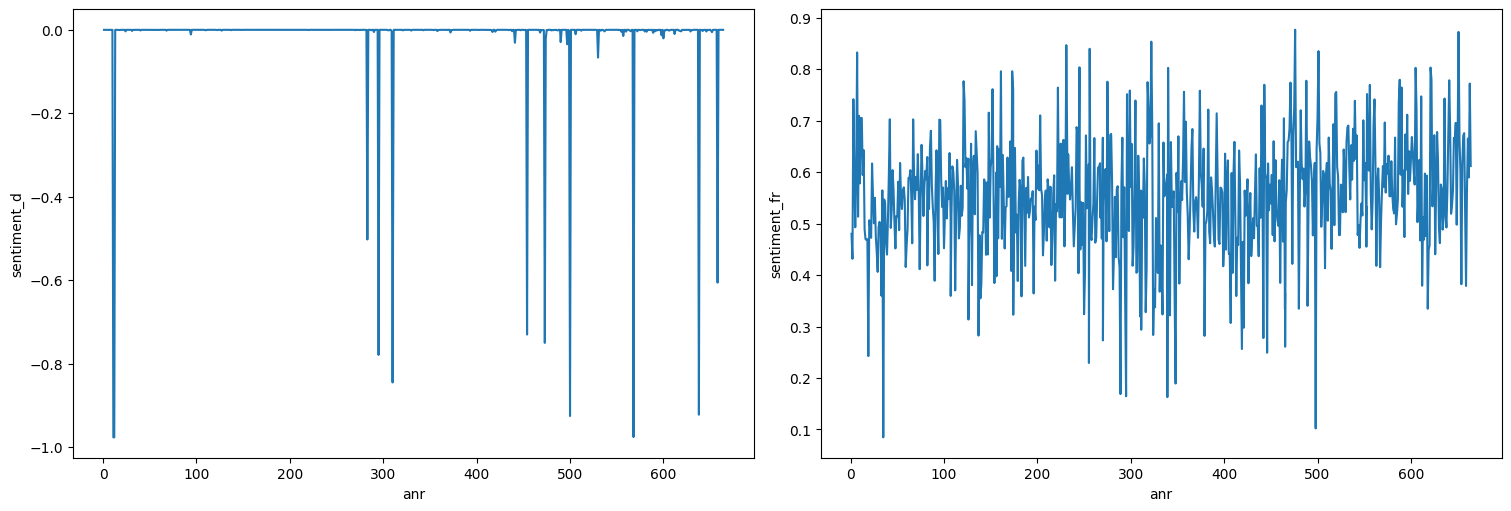

In [74]:
fig, axs = plt.subplots(nrows=1,ncols=2, layout='constrained',figsize=(15,5))
sns.lineplot(data=text_data, x='anr', y="sentiment_d", ax=axs[0])
sns.lineplot(data=text_data, x='anr', y="sentiment_fr", ax=axs[1])

<Axes: xlabel='sentiment_fr', ylabel='Count'>

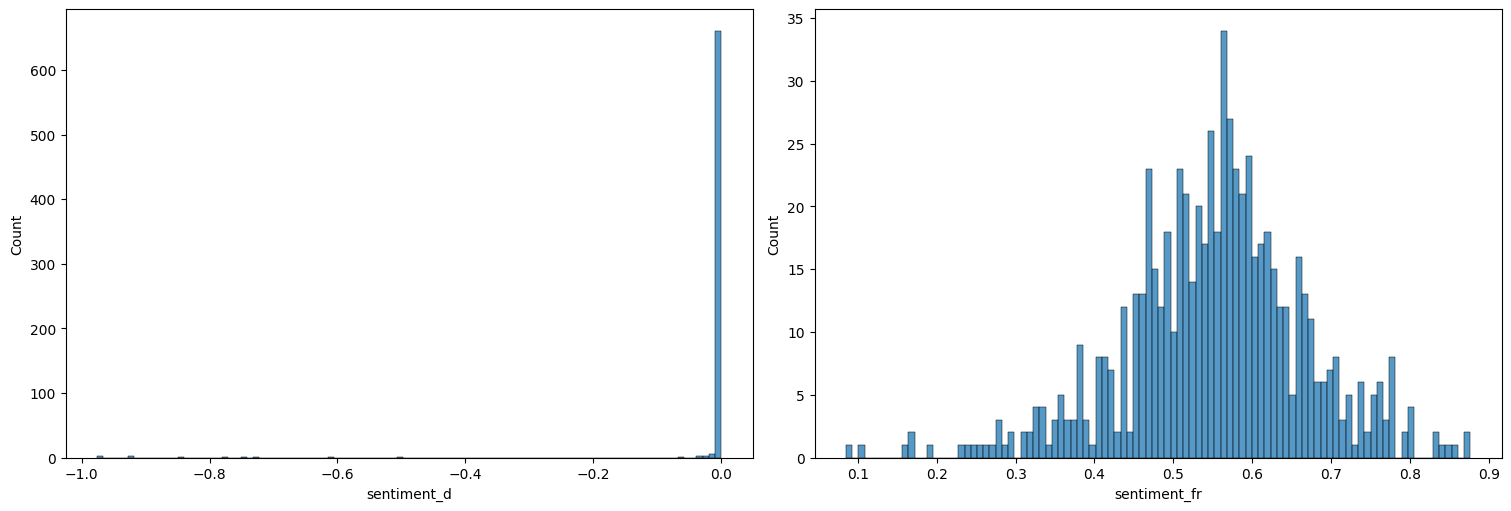

In [75]:
fig, axs = plt.subplots(nrows=1,ncols=2, layout='constrained',figsize=(15,5))
sns.histplot(data=text_data, x='sentiment_d', bins=100, ax=axs[0])
sns.histplot(data=text_data, x='sentiment_fr', bins=100, ax=axs[1])

In [76]:
from transformers import pipeline

# Create a sentiment analysis pipeline
sentiment_classifier = pipeline("sentiment-analysis", model="bert-base-multilingual-uncased")

# Define a list of texts in different languages
texts = [
    "I hate this movie",
    "Je déteste ce livre",
    "Me encanta este restaurante",
    "Ich hasse diesen Film",
    "Amo questo libro"
]

# Analyze sentiment for each text
for text in texts:
    result = sentiment_classifier(text)
    print(result)
    sentiment = result[0]['label']
    score = result[0]['score']
    #print(f"Text: {text}")
    #print(f"Score: {score}")
    ##print(f"Sentiment: {sentiment}")
    #print("\n")


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingu

[{'label': 'LABEL_1', 'score': 0.5337402820587158}]
[{'label': 'LABEL_1', 'score': 0.5301352143287659}]
[{'label': 'LABEL_1', 'score': 0.528253436088562}]
[{'label': 'LABEL_1', 'score': 0.5294137001037598}]
[{'label': 'LABEL_1', 'score': 0.5311954021453857}]


In [77]:
sentiment = pipeline(task="sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [78]:
def get_bert_label(text):
    return sentiment(text)[0]['label']
def get_bert_score(text):
    return sentiment(text)[0]['score']
def get_bert(text):
    return sentiment(text)[0]

In [79]:
text_data['sentiment_d_bert_label'] = text_data['titel_off_d'].progress_apply(get_bert_label)
text_data['sentiment_fr_bert_label'] = text_data['titel_off_f'].progress_apply(get_bert_label)
text_data['sentiment_d_bert_score'] = text_data['titel_off_d'].progress_apply(get_bert_score)
text_data['sentiment_fr_bert_score'] = text_data['titel_off_f'].progress_apply(get_bert_score)

100%|██████████| 683/683 [00:13<00:00, 50.64it/s]


In [80]:
text_data.head(10)

,anr,datum,titel_kurz_d,titel_kurz_f,titel_off_d,titel_off_f,sentiment_d,sentiment_fr,sentiment_d_bert_label,sentiment_fr_bert_label,sentiment_d_bert_score,sentiment_fr_bert_score
0,1.0,12.09.1848,Bundesverfassung der schweizerischen Eidgenoss...,Constitution fédérale de la Confédération suisse,Totalrevision vom 12. September 1848,Révision totale du 12 septembre 1848,-0.000054,0.480089,NEGATIVE,POSITIVE,0.760317,0.961079
1,2.0,14.01.1866,Mass und Gewicht,Poids et mesures,Festsetzung von Mass und Gewicht,Poids et mesures,-0.000044,0.431590,NEGATIVE,NEGATIVE,0.925410,0.877566
2,3.0,14.01.1866,Gleichstellung der Juden und Naturalisierten m...,Egalité des Juifs,Gleichstellung der Juden und Naturalisierten m...,Egalité des citoyens au point de vue de l'étab...,-0.000003,0.741770,NEGATIVE,POSITIVE,0.744371,0.874233
3,4.0,14.01.1866,Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",-0.000009,0.597496,NEGATIVE,NEGATIVE,0.989402,0.889291
4,5.0,14.01.1866,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,-0.000011,0.492853,NEGATIVE,NEGATIVE,0.924015,0.976277
5,6.0,14.01.1866,Stimmrecht der Niedergelassenen in kantonalen ...,"Droit de vote des Suisses établis, en matière ...",Stimmrecht der Niedergelassenen in kantonalen ...,"Droit de vote des Suisses établis, en matière ...",-0.000005,0.605837,NEGATIVE,NEGATIVE,0.986888,0.901213
6,7.0,14.01.1866,Glaubens- und Kultusfreiheit,Liberté de conscience et des cultes,Glaubens- und Kultusfreiheit,Liberté de conscience et des cultes,0.000266,0.832642,NEGATIVE,POSITIVE,0.966816,0.979677
7,8.0,14.01.1866,Ausschliessung einzelner Strafarten,Interdiction de certains genres de peines,Ausschliessung einzelner Strafarten,Interdiction de certains genres de peines,-0.000210,0.513442,NEGATIVE,NEGATIVE,0.930426,0.975560
8,9.0,14.01.1866,Schutz des geistigen Eigentums,"Protection de la propriété littéraire, artisti...",Schutz des geistigen Eigentums,"Protection de la propriété littéraire, artisti...",-0.000005,0.709514,NEGATIVE,POSITIVE,0.769979,0.996394
9,10.0,14.01.1866,Verbot der Lotterie und Hasardspiele,Interdiction des loteries et jeux de hasard,Verbot der Lotterie und Hasardspiele,Interdiction des loteries et jeux de hasard,-0.000143,0.578163,NEGATIVE,NEGATIVE,0.988488,0.973286


In [81]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained models for German and French
model_de = SentenceTransformer('distiluse-base-multilingual-cased')
model_fr = SentenceTransformer('distiluse-base-multilingual-cased')

# Define German and French sentences
german_sentence = "Das ist ein deutscher Satz."
french_sentence = "C'est une phrase en français."

# Compute embeddings
german_embedding = model_de.encode([german_sentence])
french_embedding = model_fr.encode([french_sentence])

# Compute cosine similarity
similarity = cosine_similarity(german_embedding, french_embedding)[0][0]

print(f"Cosine similarity: {similarity}")

Cosine similarity: 0.7874468564987183


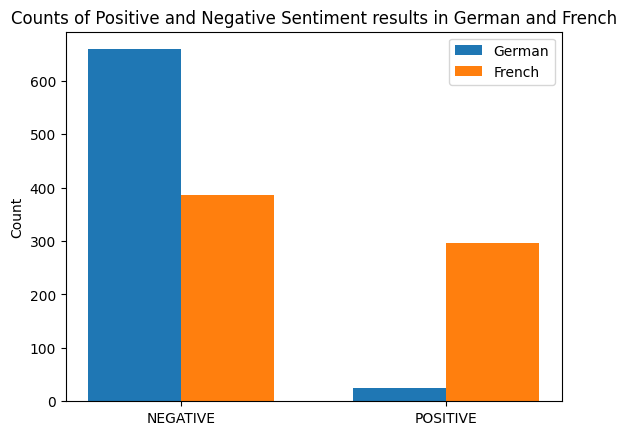

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

column1_counts = text_data['sentiment_d_bert_label'].value_counts()
column2_counts = text_data['sentiment_fr_bert_label'].value_counts()

fig, ax = plt.subplots()
x = range(len(column1_counts))
width = 0.35

rects1 = ax.bar(x, column1_counts, width, label='German')
rects2 = ax.bar([i + width for i in x], column2_counts, width, label='French')

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(column1_counts.index)

ax.set_ylabel('Count')
ax.set_title('Counts of Positive and Negative Sentiment results in German and French')
ax.legend()

plt.show()
